In [140]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
### Model Validation:
from sklearn.metrics import accuracy_score, precision_score, recall_score,balanced_accuracy_score
from sklearn.metrics import precision_recall_fscore_support, f1_score, classification_report
from sklearn.metrics import roc_curve, RocCurveDisplay, log_loss
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import cross_val_score, cross_validate, KFold, StratifiedKFold
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.pipeline import Pipeline as ImPipeline

import pickle
import joblib

### Suppress Warnings:
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('clean_data.csv')

>- Please refer to the [EDA](https://github.com/Danayt09/Tanzanian_Water_Wells/blob/main/EDA.ipynb) notebook for the cleaning process towards the final data.
>- Data had repetative columns with similar information and duplicated were removed
>- Missing values were imputed with either median or mean for numeric columns and with frequent value for categorical

In [3]:
# constraction year and age of well are correlated and convey the same information
#id will also not help our model's prediction so will drop it for now
data = data.drop(['construction_year', 'id'], axis=1)

In [4]:
data.funder.value_counts(normalize=True)

funder
Others                    0.659356
Government Of Tanzania    0.153539
unknown                   0.076440
Danida                    0.054074
Hesawa                    0.033236
World Bank                0.023356
Name: proportion, dtype: float64

In [5]:
data.installer.value_counts(normalize=True)

installer
Others        0.573158
DWE           0.282264
unknown       0.076665
Government    0.028999
RWE           0.020508
Community     0.018407
Name: proportion, dtype: float64

In [6]:
# More than 50% of funder and installer are grouped as others and this isn't helpful information for our model
# I'll try the model with both and try removing them to see performance increase

In [7]:
# Changing all T/F columns 
bool_columns = data.select_dtypes(include=bool).columns
data[bool_columns] = data[bool_columns].astype(int)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57588 entries, 0 to 57587
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   funder                 57588 non-null  object 
 1   gps_height             57588 non-null  float64
 2   installer              57588 non-null  object 
 3   longitude              57588 non-null  float64
 4   latitude               57588 non-null  float64
 5   basin                  57588 non-null  object 
 6   population             57588 non-null  float64
 7   public_meeting         57588 non-null  int64  
 8   permit                 57588 non-null  int64  
 9   extraction_type_class  57588 non-null  object 
 10  management_group       57588 non-null  object 
 11  payment                57588 non-null  object 
 12  water_quality          57588 non-null  object 
 13  quantity               57588 non-null  object 
 14  source                 57588 non-null  object 
 15  so

# Preprocessing
### Target 
>- 0 = Non functional
>- 1 = Functional but needs repair
>- 2 = Functional
>>- This project is on development and we'll create a model to identify those that need repairs
>>- We'll replace 0 and 1 with 0 as needing repair
>>- Functional wells will be tagges as 1

In [9]:
data.status_group.value_counts(normalize=True)

status_group
2    0.545061
0    0.386678
1    0.068261
Name: proportion, dtype: float64

In [12]:
data['status_group']= data['status_group'].replace({0:0, 1:0, 2:1})

In [13]:
data.status_group.value_counts(normalize=True)

status_group
1    0.545061
0    0.454939
Name: proportion, dtype: float64

In [33]:
X= data.drop('status_group', axis =1)
y= data['status_group']

In [34]:
# Spliting the data at random 
X_t, X_test, y_t, y_test = train_test_split(X,y, test_size = 0.2, random_state=42)

In [36]:
X_train, X_val, y_train, y_val = train_test_split(X_t,
                                                    y_t,
                                                    random_state=42,
                                                    test_size=0.15)

>- Seperating categorical, numeric and binary columns
>- Have our columns pass through a transformer
>- Impute missing values and one hot encode

In [37]:
cat_cols = ['installer', 'funder', 'basin', 'management_group', 'extraction_type_class', 'payment', 'water_quality', 
              'quantity', 'source', 'source_class', 'waterpoint_type_group']

num_cols = ['gps_height', 'population', 'age_of_well', 'permit', 'public_meeting']

In [38]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent',add_indicator=True)),
    ('encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'))
    
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(add_indicator=True, strategy='median')),
    ('scaler', StandardScaler())
])

In [39]:
test = selector(dtype_include=object)
test(X)

['funder',
 'installer',
 'basin',
 'extraction_type_class',
 'management_group',
 'payment',
 'water_quality',
 'quantity',
 'source',
 'source_class',
 'waterpoint_type_group']

In [40]:
numtest = selector(dtype_include=np.number)
numtest(X)

['gps_height',
 'longitude',
 'latitude',
 'population',
 'public_meeting',
 'permit',
 'age_of_well']

In [41]:
CT = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat_cols),
        ('num', numerical_transformer, num_cols)
    ])

# Evaluation Class
### How it works:
>- Constructor method (init): Initializes the EvaluationMetrics class with the machine learning pipeline and data for training, testing, and validation.
>- print_scores: Calculates and returns evaluation metrics (accuracy, recall, precision, F1-score, log loss) for the training, test, and validation sets.
>- cross_validation: Performs cross-validation on the training data using the pipeline and returns the mean and standard deviation of accuracy scores.
>- plot_roc_curve_ovr: Plots the Receiver Operating Characteristic (ROC) curve for each class in a one-vs-rest fashion.
>- plot_confusion_matrix: Plots the confusion matrix for the training data.
>- record_results: Records the evaluation metrics for a particular model in a pandas DataFrame.

In [47]:
class EvaluationMetrics:
    #model_df =[]
    model_df = pd.DataFrame(columns=['Model', 'Train Accuracy', 'Train Recall', 'Train Precision', 'Train F1-Score',
                                              'Train Log Loss','Test Accuracy', 'Test Recall', 'Test Precision', 'Test F1-Score',
                                              'Test Log Loss', 'Validation Accuracy', 'Validation Recall', 'Validation Precision',
                                              'Validation F1-Score'])

    def __init__(self, pipe, X_train, X_test, y_train, y_test, X_val, y_val):
        self.pipe = pipe
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.X_val = X_val
        self.y_val = y_val

    def print_scores(self):
        # Training set predictions
        y_train_pred = self.pipe.predict(self.X_train)
        y_train_pred_proba = self.pipe.predict_proba(self.X_train)
        train_results_dict = {'accuracy': accuracy_score(self.y_train, y_train_pred),
                              'recall': recall_score(self.y_train, y_train_pred, average='weighted'),
                              'precision': precision_score(self.y_train, y_train_pred, average='weighted'),
                              'f1_score': f1_score(self.y_train, y_train_pred, average='weighted'),
                              'log_loss': log_loss(self.y_train, y_train_pred_proba)}

        # Test set predictions
        y_test_pred = self.pipe.predict(self.X_test)
        y_test_pred_proba = self.pipe.predict_proba(self.X_test)
        test_results_dict = {'accuracy': accuracy_score(self.y_test, y_test_pred),
                             'recall': recall_score(self.y_test, y_test_pred, average='weighted'),
                             'precision': precision_score(self.y_test, y_test_pred, average='weighted'),
                             'f1_score': f1_score(self.y_test, y_test_pred, average='weighted'),
                             'log_loss': log_loss(self.y_test, y_test_pred_proba)}

        # Validation set predictions
        y_val_pred = self.pipe.predict(self.X_val)
        y_val_pred_proba = self.pipe.predict_proba(self.X_val)
        val_results_dict = {'accuracy': accuracy_score(self.y_val, y_val_pred),
                            'recall': recall_score(self.y_val, y_val_pred, average='weighted'),
                            'precision': precision_score(self.y_val, y_val_pred, average='weighted'),
                            'f1_score': f1_score(self.y_val, y_val_pred, average='weighted'),
                            'log_loss': log_loss(self.y_val, y_val_pred_proba)}

        return train_results_dict, test_results_dict, val_results_dict

    def cross_validation(self, cv=5):
        scores = cross_val_score(self.pipe, self.X_train, self.y_train, cv=cv, scoring='accuracy')
        return np.mean(scores), np.std(scores)

    # Plots ROC curve for all classes
    def plot_roc_curve_ovr(self):
        # Calculate FPR and TPR for each class (One-vs-Rest)
        y_test_pred_proba = self.pipe.predict_proba(self.X_test)
        n_classes = y_test_pred_proba.shape[1]
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(self.y_test, y_test_pred_proba[:, i], pos_label=i)

        # Plot ROC curve for each class (One-vs-Rest)
        plt.figure()
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], label=f'Class {i}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve - One-vs-Rest')
        plt.legend(loc="lower right")
        plt.show()

    # Plots confusion matrix
    def plot_confusion_matrix(self, y_train, y_train_pred):
        cm = confusion_matrix(y_train, y_train_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()

    def record_results(self, model_name, train_results, test_results, val_results):
        new_row = {'Model': model_name,
               'Train Accuracy': train_results['accuracy'],
               'Train Recall': train_results['recall'],
               'Train Precision': train_results['precision'],
               'Train F1-Score': train_results['f1_score'],
               'Train Log Loss': train_results['log_loss'],
               'Test Accuracy': test_results['accuracy'],
               'Test Recall': test_results['recall'],
               'Test Precision': test_results['precision'],
               'Test F1-Score': test_results['f1_score'],
               'Test Log Loss': test_results['log_loss'],
               'Validation Accuracy': val_results['accuracy'],
               'Validation Recall': val_results['recall'],
               'Validation Precision': val_results['precision'],
               'Validation F1-Score': val_results['f1_score'],
               'Validation Log Loss': val_results['log_loss']}
        new_row_df= pd.DataFrame(new_row, index=[0])
        self.model_df = pd.concat([self.model_df, new_row_df],ignore_index=True)

# Baseline model using a dummyregressor
>- Our baseline performed at 54% accuracy 
>- This makes sence as we've class imbalance and it's predicting true for all majority class #1
>- Next model will be Logistic regression

In [48]:
dummy_model = Pipeline(steps=[
    ('ct',CT),
    ('dummy',DummyClassifier(strategy='most_frequent', random_state=42))
])

In [52]:
dummy_model.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['installer', 'funder',
                                                   'basin', 'management_group',
                                                   'extraction_type_class',
                                                   'payment', 'water_quality',
                                                   'quantity', 'source',
                                                   'source_class',
                                                   'waterpoint_type_group']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['gps_height', 'population',
                                                   'age_of_well', 'permit',
                                                   'public_meeting'])])),
                ('dummy',
                 DummyClassifier(random_state=42, strategy='most_frequent'))])

In [53]:
dummy_metrics = EvaluationMetrics(dummy_model, X_train, X_test, y_train, y_test, X_val, y_val)
train_results, test_results, val_results = dummy_metrics.print_scores()
dummy_metrics.record_results('DummyModel', train_results, test_results, val_results)

In [54]:
dummy_metrics.model_df

Model  Train Accuracy  Train Recall  Train Precision  Train F1-Score  \
0  DummyModel        0.545111      0.545111         0.297146        0.384627   

   Train Log Loss  Test Accuracy  Test Recall  Test Precision  Test F1-Score  \
0       16.395863       0.547057     0.547057        0.299271       0.386891   

   Test Log Loss  Validation Accuracy  Validation Recall  \
0      16.325728             0.541456           0.541456   

   Validation Precision  Validation F1-Score  Validation Log Loss  
0              0.293174             0.380386            16.527614

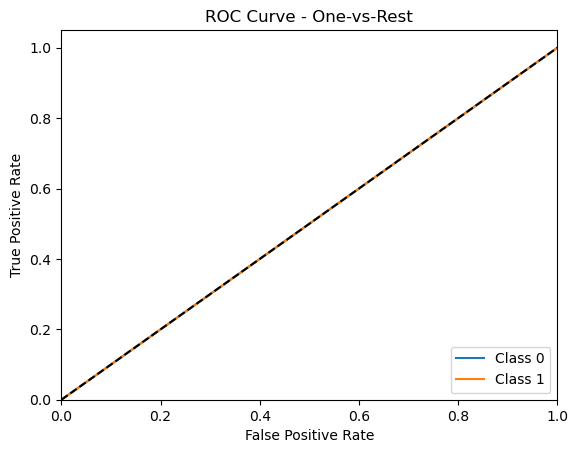

In [55]:
dummy_metrics.plot_roc_curve_ovr()

In [ ]:
print(classification_report(y_test, y_test_pred1)) 
cm = confusion_matrix(y_test, y_test_pred1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

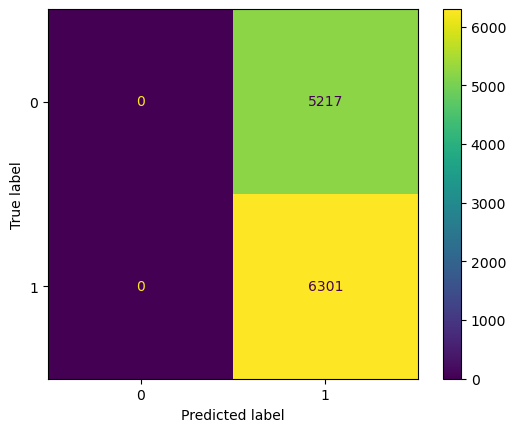

In [61]:
y_train_pred = dummy_model.predict(X_train)
dummy_metrics.plot_confusion_matrix(y_train, y_train_pred)

# Logistic Regression
>- This model performed significantly better than our baseline
>- But the balanced accuracy is still low, indicating our model is biased towards the majority class
>- We'll try different parameters and see if we can improve performance as well as class imbalance
>>-Train Accuracy: 0.7298241805947471
>>-Test Accuracy: 0.7257336343115124

>>-Train Accuracy: 0.5082261808855584
>>-Test Accuracy: 0.5055801344470208

In [63]:
lr1 = Pipeline(steps=[
    ('ct', CT),
    ('classifier', LogisticRegression(random_state =42, n_jobs=-1))
])

In [64]:
lr1.fit(X_train, y_train)

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['installer', 'funder',
                                                   'basin', 'management_group',
                                                   'extraction_type_class',
                                                   'payment', 'water_quality',
                                                   'quantity', 'source',
                                                   'source_class',
                                                   'waterpoint_type_group']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['gps_height', 'population',
                                                   'age_of_well', 'permit',
                                                   'public_meeting'])])),
                ('classifier', LogisticRegression(n_jobs=-1, random_state=42))])

In [65]:
lr1_metrics = EvaluationMetrics(lr1, X_train, X_test, y_train, y_test, X_val, y_val)
train_results, test_results, val_results = lr1_metrics.print_scores()
lr1_metrics.record_results('LR', train_results, test_results, val_results)

In [66]:
lr1_metrics.model_df

Model  Train Accuracy  Train Recall  Train Precision  Train F1-Score  \
0    LR        0.746648      0.746648         0.754621        0.740698   

   Train Log Loss  Test Accuracy  Test Recall  Test Precision  Test F1-Score  \
0        0.503817       0.742056     0.742056        0.749096       0.736028   

   Test Log Loss  Validation Accuracy  Validation Recall  \
0       0.509481             0.744031           0.744031   

   Validation Precision  Validation F1-Score  Validation Log Loss  
0              0.751517             0.738547             0.510594

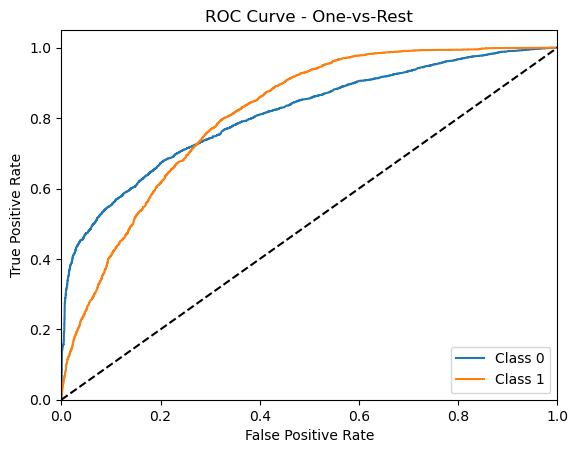

In [67]:
lr1_metrics.plot_roc_curve_ovr()

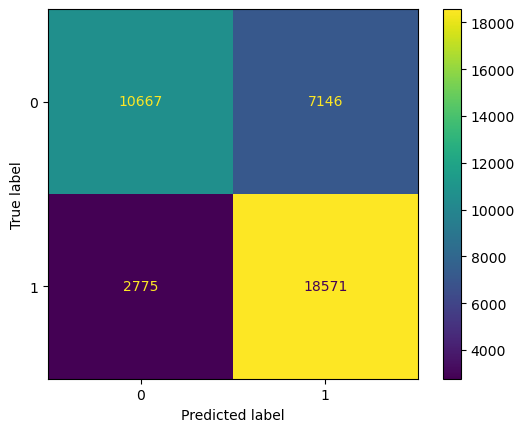

In [69]:
y_train_pred = lr1.predict(X_train)
lr1_metrics.plot_confusion_matrix(y_train, y_train_pred)

# Model Tunining 
>- will first look into the available parameters we can change and use the most applicable to our case
>- Creating another logistic regression with improved prameters
>- Will be srating with 'classifier__class_weight', 'classifier__multi_class', 'classifier__solver'
>>Train Accuracy: 0.74
>>
>>Test Accuracy: 0.74
>>
>>Val Accuracy: 0.74
>>
>>logloss: 0.50

In [56]:
lr1.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'ct', 'classifier', 'ct__n_jobs', 'ct__remainder', 'ct__sparse_threshold', 'ct__transformer_weights', 'ct__transformers', 'ct__verbose', 'ct__verbose_feature_names_out', 'ct__cat', 'ct__num', 'ct__cat__memory', 'ct__cat__steps', 'ct__cat__verbose', 'ct__cat__imputer', 'ct__cat__encoder', 'ct__cat__imputer__add_indicator', 'ct__cat__imputer__copy', 'ct__cat__imputer__fill_value', 'ct__cat__imputer__keep_empty_features', 'ct__cat__imputer__missing_values', 'ct__cat__imputer__strategy', 'ct__cat__encoder__categories', 'ct__cat__encoder__drop', 'ct__cat__encoder__dtype', 'ct__cat__encoder__feature_name_combiner', 'ct__cat__encoder__handle_unknown', 'ct__cat__encoder__max_categories', 'ct__cat__encoder__min_frequency', 'ct__cat__encoder__sparse', 'ct__cat__encoder__sparse_output', 'ct__num__memory', 'ct__num__steps', 'ct__num__verbose', 'ct__num__imputer', 'ct__num__scaler', 'ct__num__imputer__add_indicator', 'ct__num__imputer__copy', 'ct__num__imput

In [70]:
lr2 = Pipeline(steps=[
    ('ct', CT),
    ('classifier', LogisticRegression(random_state =42, multi_class='multinomial', class_weight='balanced', n_jobs=-1))
])

In [71]:
lr2.fit(X_train, y_train)

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['installer', 'funder',
                                                   'basin', 'management_group',
                                                   'extraction_type_class',
                                                   'payment', 'water_quality',
                                                   'quantity', 'source',
                                                   'source_class',
                                                   'waterpoint_type_group']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['gps_height', 'population',
                                                   'age_of_well', 'permit',
                                                   'public_meeting'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced',
                                    multi_class='multinomial', n_jobs=-1,
                                    random_state=42))])

In [72]:
lr2_metrics = EvaluationMetrics(lr2, X_train, X_test, y_train, y_test, X_val, y_val)
train_results, test_results, val_results = lr2_metrics.print_scores()
lr2_metrics.record_results('LR_Balanced', train_results, test_results, val_results)

In [73]:
lr2_metrics.model_df

Model  Train Accuracy  Train Recall  Train Precision  Train F1-Score  \
0  LR_Balanced        0.745678      0.745678         0.746996        0.742989   

   Train Log Loss  Test Accuracy  Test Recall  Test Precision  Test F1-Score  \
0        0.506606       0.742577     0.742577        0.743551       0.739864   

   Test Log Loss  Validation Accuracy  Validation Recall  \
0       0.512553             0.744031           0.744031   

   Validation Precision  Validation F1-Score  Validation Log Loss  
0              0.745458             0.741517             0.513416

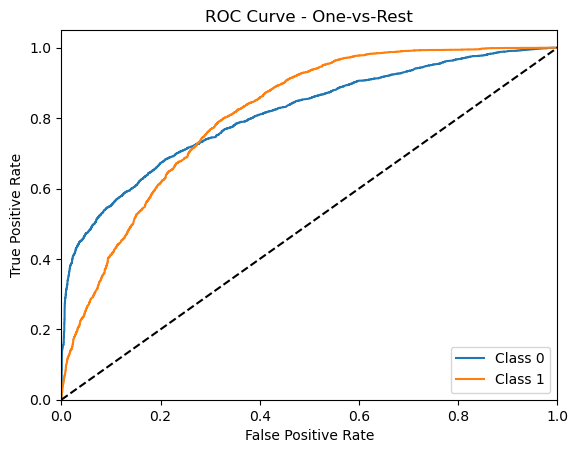

In [74]:
lr2_metrics.plot_roc_curve_ovr()

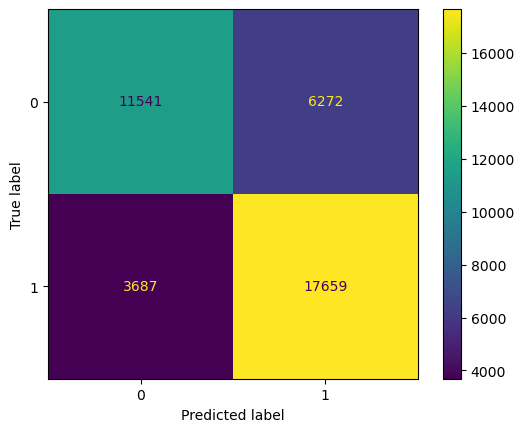

In [75]:
y_train_pred = lr2.predict(X_train)
lr2_metrics.plot_confusion_matrix(y_train, y_train_pred)

# Grid Search 
>- Will be using grid search to find the best parameters for our model
>- Found the best prams with L1 and ovr multi class computation.
>- Our result did improve but the classes aren't balanced
>- Next We'll try the best params with smote to see if the imbalance will improve

In [76]:
gr1 = Pipeline(steps=[
    ('ct', CT),
    ('classifier', LogisticRegression(random_state =42))
])

In [77]:
param_grid = {
    'classifier__C': [0.0001,0.001,0.1, 1, 10],
    'classifier__penalty': ['l2', 'l1', 'elasticnet'],
    'classifier__solver':['lbfgs', 'liblinear', 'saga'],
    'classifier__l1_ratio':[0.2, 0.8],
    'classifier__max_iter':[100, 1000, 10000],
    'classifier__multi_class': ['multinomial','ovr'],
    'classifier__class_weight': ['balanced']
    
}

In [78]:
grid_search_lr = GridSearchCV(gr1, param_grid, cv= 5, verbose = 2, n_jobs=-1)

In [79]:
grid_search_lr.fit(X_train, y_train)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (pen

[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=multinomial, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.4s
[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=multinomial, classifier__penalty=l1, classifier__solver=lbfgs; total time=   0.1s
[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=multinomial, classifier__penalty=l1, classifier__solver=lbfgs; total time=   0.2s
[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=multinomial, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifi

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: Fu

[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=multinomial, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.4s
[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=multinomial, classifier__penalty=l2, classifier__solver=saga; total time=   0.7s
[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=multinomial, classifier__penalty=elasticnet, classifier__solver=lbfgs; total time=   0.2s
[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=multinomial, classifier__penalty=elasticnet, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__l1_rati

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: Fu

[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=multinomial, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.3s
[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=multinomial, classifier__penalty=l2, classifier__solver=saga; total time=   0.7s
[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=multinomial, classifier__penalty=l1, classifier__solver=saga; total time=   0.2s
[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=multinomial, classifier__penalty=elasticnet, classifier__solver=saga; total time=   0.9s
[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, cla

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: Fu

[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=multinomial, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=multinomial, classifier__penalty=l2, classifier__solver=saga; total time=   0.6s
[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=multinomial, classifier__penalty=l1, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=multinomial, classifier__penalty=elasticnet, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__l1_ratio=0.2

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/si

[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=multinomial, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.4s
[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=multinomial, classifier__penalty=l1, classifier__solver=lbfgs; total time=   0.1s
[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=multinomial, classifier__penalty=l1, classifier__solver=lbfgs; total time=   0.1s
[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=multinomial, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifi

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: Fu

[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=multinomial, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.4s
[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=multinomial, classifier__penalty=l1, classifier__solver=lbfgs; total time=   0.1s
[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=multinomial, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=multinomial, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, clas

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (pen

[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=multinomial, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=multinomial, classifier__penalty=l2, classifier__solver=saga; total time=   0.7s
[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=multinomial, classifier__penalty=l1, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=multinomial, classifier__penalty=elasticnet, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__l1_ratio=0.2

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: Fu

[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=multinomial, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=multinomial, classifier__penalty=l1, classifier__solver=saga; total time=   0.7s
[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=multinomial, classifier__penalty=l1, classifier__solver=saga; total time=   1.2s
[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=ovr, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.3s
[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=10

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: Fu

[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__l1_ratio=0.8, classifier__max_iter=10000, classifier__multi_class=ovr, classifier__penalty=elasticnet, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=multinomial, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.4s
[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=multinomial, classifier__penalty=l1, classifier__solver=lbfgs; total time=   0.2s
[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=multinomial, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier_

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


nced, classifier__l1_ratio=0.2, classifier__max_iter=1000, classifier__multi_class=ovr, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.2s
[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=1000, classifier__multi_class=ovr, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=1000, classifier__multi_class=ovr, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=1000, classifier__multi_class=ovr, classifier__penalty=l2, classifier__solver=saga; total time=   0.6s
[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=1000, classifier__multi_class=ovr, classifier__penalty=l1, classifier__solve

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoder

[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=ovr, classifier__penalty=l1, classifier__solver=saga; total time=   1.3s
[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=ovr, classifier__penalty=elasticnet, classifier__solver=saga; total time=   0.9s
[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=1000, classifier__multi_class=multinomial, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=1000, classifier__multi_class=multinomial, classifier__penalty=l2, classifier__solver=saga; total time=   2.2s
[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=1

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (pen

[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=ovr, classifier__penalty=elasticnet, classifier__solver=lbfgs; total time=   0.2s
[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=ovr, classifier__penalty=elasticnet, classifier__solver=lbfgs; total time=   0.1s
[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=ovr, classifier__penalty=elasticnet, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=ovr, classifier__penalty=elasticnet, classifier__solver=saga; total time=   0.9s
[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__ma

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: Fu

[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=multinomial, classifier__penalty=elasticnet, classifier__solver=lbfgs; total time=   0.2s
[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=multinomial, classifier__penalty=elasticnet, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=multinomial, classifier__penalty=elasticnet, classifier__solver=saga; total time=   1.4s
[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=ovr, classifier__penalty=l1, classifier__solver=lbfgs; total time=   0.2s
[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=0.2

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: Us

[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=multinomial, classifier__penalty=l1, classifier__solver=saga; total time=   1.0s
[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=multinomial, classifier__penalty=elasticnet, classifier__solver=lbfgs; total time=   0.2s
[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=multinomial, classifier__penalty=elasticnet, classifier__solver=lbfgs; total time=   0.2s
[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=multinomial, classifier__penalty=elasticnet, classifier__solver=saga; total time=   1.3s
[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: Fu

[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=ovr, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.2s
[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=ovr, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.3s
[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=ovr, classifier__penalty=l2, classifier__solver=saga; total time=   1.8s
[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=ovr, classifier__penalty=l1, classifier__solver=saga; total time=   1.1s
[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=1000, classifier__multi_cl

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: Us

[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=ovr, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.3s
[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=ovr, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=ovr, classifier__penalty=l2, classifier__solver=saga; total time=   2.0s
[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=ovr, classifier__penalty=elasticnet, classifier__solver=lbfgs; total time=   0.1s
[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifi

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (pen

[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=ovr, classifier__penalty=elasticnet, classifier__solver=lbfgs; total time=   0.2s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=ovr, classifier__penalty=elasticnet, classifier__solver=lbfgs; total time=   0.1s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=ovr, classifier__penalty=elasticnet, classifier__solver=lbfgs; total time=   0.1s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=ovr, classifier__penalty=elasticnet, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=10

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be r

[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=multinomial, classifier__penalty=elasticnet, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=multinomial, classifier__penalty=elasticnet, classifier__solver=saga; total time=   5.0s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=ovr, classifier__penalty=l1, classifier__solver=lbfgs; total time=   0.1s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=ovr, classifier__penalty=l1, classifier__solver=lbfgs; total time=   0.1s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  war

[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=0.8, classifier__max_iter=10000, classifier__multi_class=ovr, classifier__penalty=l1, classifier__solver=lbfgs; total time=   0.2s
[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=0.8, classifier__max_iter=10000, classifier__multi_class=ovr, classifier__penalty=l1, classifier__solver=lbfgs; total time=   0.1s
[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=0.8, classifier__max_iter=10000, classifier__multi_class=ovr, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=0.8, classifier__max_iter=10000, classifier__multi_class=ovr, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=0.001, classifier__class_weight=balanced, classifier__l1_ratio=0.8, classifier__max_iter=10000, class

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be r

[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=1000, classifier__multi_class=multinomial, classifier__penalty=l1, classifier__solver=saga; total time=  17.2s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=1000, classifier__multi_class=ovr, classifier__penalty=l2, classifier__solver=saga; total time=   5.8s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=1000, classifier__multi_class=ovr, classifier__penalty=elasticnet, classifier__solver=lbfgs; total time=   0.1s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=1000, classifier__multi_class=ovr, classifier__penalty=elasticnet, classifier__solver=lbfgs; total time=   0.1s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=1000, classi

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4.

[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=1000, classifier__multi_class=multinomial, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.9s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=1000, classifier__multi_class=multinomial, classifier__penalty=l2, classifier__solver=lbfgs; total time=   1.0s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=1000, classifier__multi_class=multinomial, classifier__penalty=l2, classifier__solver=saga; total time=   9.6s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=1000, classifier__multi_class=multinomial, classifier__penalty=elasticnet, classifier__solver=saga; total time=   6.1s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_i

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (pen

[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=1000, classifier__multi_class=ovr, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.5s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=1000, classifier__multi_class=ovr, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.4s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=1000, classifier__multi_class=ovr, classifier__penalty=l1, classifier__solver=liblinear; total time=   1.0s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=1000, classifier__multi_class=ovr, classifier__penalty=l1, classifier__solver=saga; total time=  21.6s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=10000, classifier__mult

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be r

[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=multinomial, classifier__penalty=elasticnet, classifier__solver=saga; total time=   5.0s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=ovr, classifier__penalty=l2, classifier__solver=saga; total time=   2.8s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=ovr, classifier__penalty=elasticnet, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=ovr, classifier__penalty=elasticnet, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its defaul

[CV] END classifier__C=1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=ovr, classifier__penalty=l1, classifier__solver=lbfgs; total time=   0.1s
[CV] END classifier__C=1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=ovr, classifier__penalty=l1, classifier__solver=liblinear; total time=   1.4s
[CV] END classifier__C=1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=100, classifier__multi_class=ovr, classifier__penalty=l1, classifier__solver=saga; total time=   3.3s
[CV] END classifier__C=1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=1000, classifier__multi_class=multinomial, classifier__penalty=l2, classifier__solver=lbfgs; total time=   1.2s
[CV] END classifier__C=1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=1000, classifier__multi_class=multin

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (pen

[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__l1_ratio=0.8, classifier__max_iter=10000, classifier__multi_class=ovr, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.5s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__l1_ratio=0.8, classifier__max_iter=10000, classifier__multi_class=ovr, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.3s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__l1_ratio=0.8, classifier__max_iter=10000, classifier__multi_class=ovr, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.3s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__l1_ratio=0.8, classifier__max_iter=10000, classifier__multi_class=ovr, classifier__penalty=l2, classifier__solver=saga; total time=   5.5s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__l1_ratio=0.8, classifier__max_iter=10000, classifier__mult

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (pen

[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=1000, classifier__multi_class=ovr, classifier__penalty=l1, classifier__solver=saga; total time=  20.2s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=10000, classifier__multi_class=multinomial, classifier__penalty=l1, classifier__solver=saga; total time=   3.2s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=10000, classifier__multi_class=multinomial, classifier__penalty=elasticnet, classifier__solver=saga; total time=  13.3s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=10000, classifier__multi_class=ovr, classifier__penalty=l1, classifier__solver=lbfgs; total time=   0.1s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=10000, cla

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: Fu

[CV] END classifier__C=1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=1000, classifier__multi_class=multinomial, classifier__penalty=l1, classifier__solver=saga; total time=  36.3s
[CV] END classifier__C=1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=1000, classifier__multi_class=ovr, classifier__penalty=l1, classifier__solver=saga; total time=  12.7s
[CV] END classifier__C=1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=1000, classifier__multi_class=ovr, classifier__penalty=elasticnet, classifier__solver=saga; total time=   4.1s
[CV] END classifier__C=1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=10000, classifier__multi_class=multinomial, classifier__penalty=l2, classifier__solver=lbfgs; total time=   1.1s
[CV] END classifier__C=1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=10000, classifier__mul

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: Fu

[CV] END classifier__C=1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=1000, classifier__multi_class=ovr, classifier__penalty=elasticnet, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=1000, classifier__multi_class=ovr, classifier__penalty=elasticnet, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=1000, classifier__multi_class=ovr, classifier__penalty=elasticnet, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=1000, classifier__multi_class=ovr, classifier__penalty=elasticnet, classifier__solver=saga; total time=  12.2s
[CV] END classifier__C=1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=1

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: Fu

[CV] END classifier__C=1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=1000, classifier__multi_class=multinomial, classifier__penalty=l1, classifier__solver=lbfgs; total time=   0.1s
[CV] END classifier__C=1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=1000, classifier__multi_class=multinomial, classifier__penalty=l1, classifier__solver=lbfgs; total time=   0.1s
[CV] END classifier__C=1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=1000, classifier__multi_class=multinomial, classifier__penalty=l1, classifier__solver=lbfgs; total time=   0.1s
[CV] END classifier__C=1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=1000, classifier__multi_class=multinomial, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=1000, cl

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sk

[CV] END classifier__C=1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=1000, classifier__multi_class=ovr, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.6s
[CV] END classifier__C=1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=1000, classifier__multi_class=ovr, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.7s
[CV] END classifier__C=1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=1000, classifier__multi_class=ovr, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.6s
[CV] END classifier__C=1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=1000, classifier__multi_class=ovr, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.6s
[CV] END classifier__C=1, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=1000, classifier__multi_class=ovr, classifie

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: Fu

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=True,
                                                                                                        strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['installer',
                                                                          'funder',
                                                                          'basin',
                                                                          'management_group',
                                                                          'extraction_type_class',
                                                                          'payment',
                                                                          'water_quality',
                                                                          'quantity...
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.0001, 0.001, 0.1, 1, 10],
                         'classifier__class_weight': ['balanced'],
                         'classifier__l1_ratio': [0.2, 0.8],
                         'classifier__max_iter': [100, 1000, 10000],
                         'classifier__multi_class': ['multinomial', 'ovr'],
                         'classifier__penalty': ['l2', 'l1', 'elasticnet'],
                         'classifier__solver': ['lbfgs', 'liblinear', 'saga']},
             verbose=2)

[CV] END classifier__C=10, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=1000, classifier__multi_class=ovr, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.7s
[CV] END classifier__C=10, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=1000, classifier__multi_class=ovr, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.7s
[CV] END classifier__C=10, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=1000, classifier__multi_class=ovr, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.3s
[CV] END classifier__C=10, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=1000, classifier__multi_class=ovr, classifier__penalty=l2, classifier__solver=saga; total time=   9.9s
[CV] END classifier__C=10, classifier__class_weight=balanced, classifier__l1_ratio=0.2, classifier__max_iter=1000, classifier__multi_class=ovr, c

In [80]:
best_params_gd1 = grid_search_lr.best_params_

In [82]:
grid_lr = grid_search_lr.best_estimator_

In [91]:
grid_lr_metrics = EvaluationMetrics(grid_lr, X_train, X_test, y_train, y_test, X_val, y_val)
train_results, test_results, val_results = grid_lr_metrics.print_scores()
grid_lr_metrics.record_results('LR_Grid', train_results, test_results, val_results)

In [92]:
grid_lr_metrics.model_df

Model  Train Accuracy  Train Recall  Train Precision  Train F1-Score  \
0  LR_Grid        0.745218      0.745218         0.746781        0.742357   

   Train Log Loss  Test Accuracy  Test Recall  Test Precision  Test F1-Score  \
0        0.507387       0.742056     0.742056        0.743373       0.739083   

   Test Log Loss  Validation Accuracy  Validation Recall  \
0       0.512732             0.743452           0.743452   

   Validation Precision  Validation F1-Score  Validation Log Loss  
0              0.745329             0.740647             0.512522

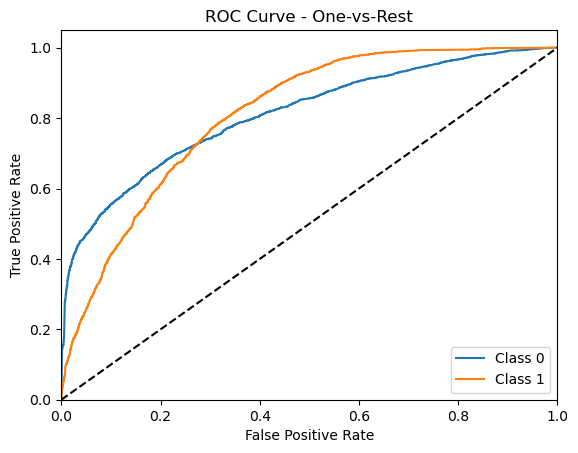

In [93]:
grid_lr_metrics.plot_roc_curve_ovr()

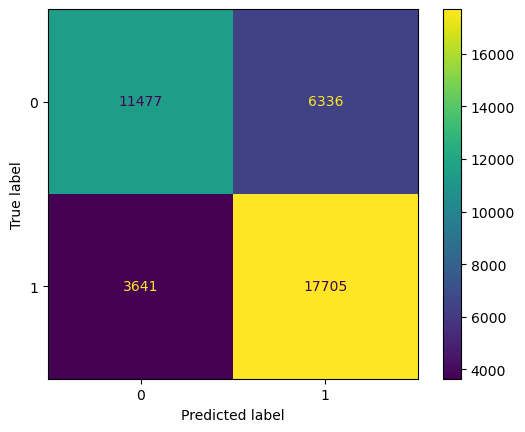

In [94]:
y_train_pred = grid_lr.predict(X_train)
grid_lr_metrics.plot_confusion_matrix(y_train, y_train_pred)

>- best grid searched regression estimator didn't improve results by much than the balnced results of LR

# Logistic regression with Smote
>- will be using the best param from logistic regression for the smote model
>- Smote and best params results are close enough to our first tuned and balanced model
>- High log loss with balanced accuracy
>- This result at ballanced accuracy of 0.610 was with L1 regularization
>- Will look into important features and reduce model complexity to see if performance increases

In [87]:
best_params_gd1

{'classifier__C': 0.1,
 'classifier__class_weight': 'balanced',
 'classifier__l1_ratio': 0.2,
 'classifier__max_iter': 100,
 'classifier__multi_class': 'ovr',
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [89]:
Smote_model = ImPipeline(steps=[
    ('ct', CT),
    ('sm', SMOTE(random_state = 42)),
    ('classifier', LogisticRegression(class_weight= 'balanced', l1_ratio= 0.2,
                                      max_iter= 100, multi_class='ovr', penalty= 'l1',
                                      solver= 'liblinear', random_state =42))
])

In [90]:
Smote_model.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['installer', 'funder',
                                                   'basin', 'management_group',
                                                   'extraction_type_class',
                                                   'payment', 'water_quality',
                                                   'quantity', 'source',
                                                   'source_class',
                                                   'w...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['gps_height', 'population',
                                                   'age_of_well', 'permit',
                                                   'public_meeting'])])),
                ('sm', SMOTE(random_state=42)),
                ('classifier',
                 LogisticRegression(class_weight='balanced', l1_ratio=0.2,
                                    multi_class='ovr', penalty='l1',
                                    random_state=42, solver='liblinear'))])

In [95]:
Smote_model_metrics = EvaluationMetrics(Smote_model, X_train, X_test, y_train, y_test, X_val, y_val)
train_results, test_results, val_results = Smote_model_metrics.print_scores()
Smote_model_metrics.record_results('LR_Smote', train_results, test_results, val_results)

In [96]:
Smote_model_metrics.model_df

Model  Train Accuracy  Train Recall  Train Precision  Train F1-Score  \
0  LR_Smote        0.745448      0.745448         0.746812        0.742722   

   Train Log Loss  Test Accuracy  Test Recall  Test Precision  Test F1-Score  \
0        0.506736       0.740493     0.740493        0.741432       0.737738   

   Test Log Loss  Validation Accuracy  Validation Recall  \
0       0.512833             0.744176           0.744176   

   Validation Precision  Validation F1-Score  Validation Log Loss  
0              0.745518              0.74172             0.513673

>- Our data wasn't that imbalanced and it makes sence that smote wasn't able to improve results by much
>- We'll try tree based descision algorithms next starting with Random forest

# Random Forest
>- Will be using a random forest to find important features as well as improve performance with several parameters
>- Model performed well on training but not so much for test data, but random trees are prone to overfit
>- Using Gridsearch we found parameters that best fit our model and reduce overfitting
>- We've train at 79%, test at 78% and validation at 78% with lof loss of 0.46
>- This is by far our best model, since this is tree based algorithm, we'll try xgboost next

In [97]:
from sklearn.ensemble import RandomForestClassifier

In [98]:
CT

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['installer', 'funder', 'basin',
                                  'management_group', 'extraction_type_class',
                                  'payment', 'water_quality', 'quantity',
                                  'source', 'source_class',
                                  'waterpoint_type_group']),
                                ('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['gps_height', 'population', 'age_of_well',
                                  'permit', 'public_meeting'])])

In [99]:
rf_pipe = Pipeline(steps=[
    ('ct', CT),
    ('classifier', RandomForestClassifier())])

In [109]:
rf_grid = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [3, 5, 7, 9, 11],
    'classifier__n_estimators':[30,50, 70, 100,150],
    'classifier__min_samples_split': [2, 3, 4, 6],
    'classifier__min_samples_leaf':[2, 4, 8, 12],
    'classifier__max_features': ["sqrt", "log2"],
    'classifier__class_weight': ['balanced']    
}

In [110]:
rf_grid_model = GridSearchCV(estimator=rf_pipe , param_grid=rf_grid, n_jobs=-1)

In [111]:
rf_grid_model.fit(X_train, y_train)

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: Fu

GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=True,
                                                                                                        strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['installer',
                                                                          'funder',
                                                                          'basin',
                                                                          'management_group',
                                                                          'extraction_type_class',
                                                                          'payment',
                                                                          'water_quality',
                                                                          'quantity',
                                                                          'so...
                                       ('classifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__class_weight': ['balanced'],
                         'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [3, 5, 7, 9, 11],
                         'classifier__max_features': ['sqrt', 'log2'],
                         'classifier__min_samples_leaf': [2, 4, 8, 12],
                         'classifier__min_samples_split': [2, 3, 4, 6],
                         'classifier__n_estimators': [30, 50, 70, 100, 150]})

In [112]:
rf_best_params = rf_grid_model.best_params_

In [113]:
rf_best_estimator = rf_grid_model.best_estimator_
rf_best_estimator

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['installer', 'funder',
                                                   'basin', 'management_group',
                                                   'extraction_type_class',
                                                   'payment', 'water_quality',
                                                   'quantity', 'source',
                                                   'source_class',
                                                   'waterpoint_type_group']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['gps_height', 'population',
                                                   'age_of_well', 'permit',
                                                   'public_meeting'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=11,
                                        min_samples_leaf=2,
                                        min_samples_split=3))])

In [119]:
rf_metrics = EvaluationMetrics(rf_best_estimator, X_train, X_test, y_train, y_test, X_val, y_val)
train_results, test_results, val_results = rf_metrics.print_scores()
rf_metrics.record_results('Rf_Grid', train_results, test_results, val_results)

In [120]:
rf_metrics.model_df

Model  Train Accuracy  Train Recall  Train Precision  Train F1-Score  \
0  Rf_Grid        0.797186      0.797186         0.807791        0.792753   

   Train Log Loss  Test Accuracy  Test Recall  Test Precision  Test F1-Score  \
0        0.466709       0.778955     0.778955         0.78706       0.774349   

   Test Log Loss  Validation Accuracy  Validation Recall  \
0       0.484497             0.781363           0.781363   

   Validation Precision  Validation F1-Score  Validation Log Loss  
0              0.789904              0.77715             0.479631

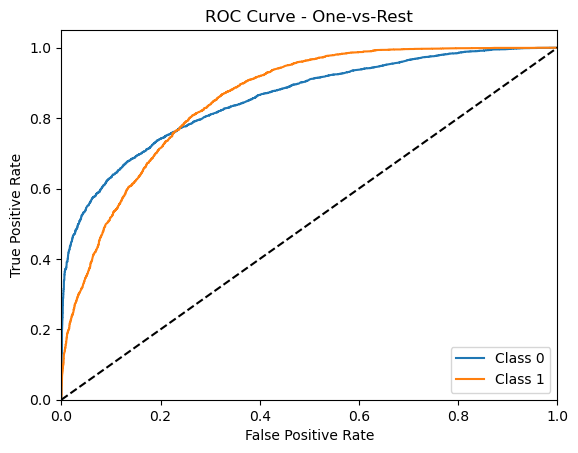

In [117]:
rf_metrics.plot_roc_curve_ovr()

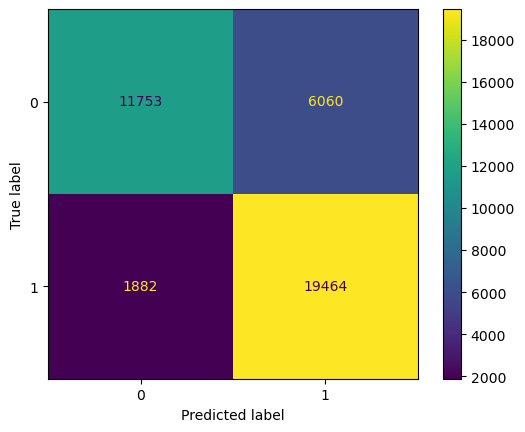

In [118]:
y_train_pred = rf_best_estimator.predict(X_train)
grid_lr_metrics.plot_confusion_matrix(y_train, y_train_pred)

In [141]:
#Saving grid searched file for future use
rf_file = 'RandomForest.pkl'
with open (rf_file,'wb') as file:
  pickle.dump(rf_best_estimator, file)

### Getting feature importance 

In [128]:
feature_importance = rf_best_estimator.named_steps['classifier'].feature_importances_

In [131]:
cat_encoder = rf_best_estimator.named_steps['ct'].transformers_[0][1].named_steps['encoder']
cat_feature_names = cat_encoder.get_feature_names_out(cat_cols)

In [132]:
num_feature_names = num_cols

In [133]:
feature_names = np.concatenate([cat_feature_names, num_feature_names])

In [135]:
feature_importance_df = pd.DataFrame({'Feature':feature_names, 'Importance': feature_importance})

In [137]:
feature_importance_df = feature_importance_df.sort_values(by='Importance',ascending=False)

In [190]:
feature_importance_df.tail()

Feature  Importance
60                       source_unknown    0.000236
40                water_quality_colored    0.000233
64  waterpoint_type_group_cattle trough    0.000182
32   extraction_type_class_wind-powered    0.000088
66            waterpoint_type_group_dam    0.000000

In [225]:
# Create a dictionary to map the encoded feature names to their original form 
feature_mapping = {} 
for i, feature_name in enumerate(cat_feature_names):     
    original_feature_name = feature_name.rsplit('_')[0]  
    # Assuming the original feature name is after the underscore     
feature_mapping[feature_name] = original_feature_name 

In [226]:
feature_mapping

{'waterpoint_type_group_other': 'waterpoint'}

In [227]:
original_feature_name 

'waterpoint'

In [224]:
feature_name

'installer_Community'

In [222]:
# Create a new dictionary to store the feature importances in their original form 
original_feature_importances = {} 
for feature_name, importance in zip(cat_feature_names, feature_importance):     
    original_feature_name = feature_mapping[feature_name]    
    if original_feature_name in original_feature_importances:         
        original_feature_importances[original_feature_name] += importance     
    else:         
        original_feature_importances[original_feature_name] = importance  

KeyError: 'installer_Community'

In [ ]:
        # Print the feature importances in their original form for feature_name, importance in 
original_feature_importances.items():     
print(f"{feature_name}: {importance}")

# XGBoosting
>- Since random forest performed relatively well, I tried xgboost
>- The model's performance wasn't as consistent as the previous models tried above
>- The model performed at 84% on training set and at 80% for both validation and test set
>- Performance increased from random forest by about 1% but xgboost was slightly overfit 

In [143]:
import xgboost as xgb

In [171]:
xg_params = {
    'classifier__eta':[0.1,0.001,0.001],
    'classifier__max_depth':[3,5,7],
    'classifier__n_estimators': [100,200,300],
    'classifier__colsample_bytree':[0.1, 0.3,0.5,0.7]
}

In [172]:
# generating the model
xg_reg = xgb.XGBClassifier(objective ='binary:logistic')

In [173]:
xg_pipe = Pipeline(steps=[
    ('ct', CT),
    ('classifier', xg_reg)])

In [174]:
xg_grid = GridSearchCV(estimator=xg_pipe, param_grid=xg_params,n_jobs=-1)

In [175]:
xg_grid.fit(X_train, y_train)

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: Fu

GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=True,
                                                                                                        strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['installer',
                                                                          'funder',
                                                                          'basin',
                                                                          'management_group',
                                                                          'extraction_type_class',
                                                                          'payment',
                                                                          'water_quality',
                                                                          'quantity',
                                                                          'so...
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'classifier__colsample_bytree': [0.1, 0.3, 0.5, 0.7],
                         'classifier__eta': [0.1, 0.001, 0.001],
                         'classifier__max_depth': [3, 5, 7],
                         'classifier__n_estimators': [100, 200, 300]})

In [176]:
xg_best_estimator = xg_grid.best_estimator_
xg_best_params = xg_grid.best_params_

In [177]:
xg_metrics = EvaluationMetrics(xg_best_estimator, X_train, X_test, y_train, y_test, X_val, y_val)
train_results, test_results, val_results = xg_metrics.print_scores()
xg_metrics.record_results('XG_Grid', train_results, test_results, val_results)

In [178]:
xg_metrics.model_df

Model  Train Accuracy  Train Recall  Train Precision  Train F1-Score  \
0  XG_Grid        0.845502      0.845502         0.850351        0.843773   

   Train Log Loss  Test Accuracy  Test Recall  Test Precision  Test F1-Score  \
0        0.350878       0.802483     0.802483        0.806239       0.800072   

   Test Log Loss  Validation Accuracy  Validation Recall  \
0       0.420158             0.800029           0.800029   

   Validation Precision  Validation F1-Score  Validation Log Loss  
0              0.802657             0.798209             0.419329

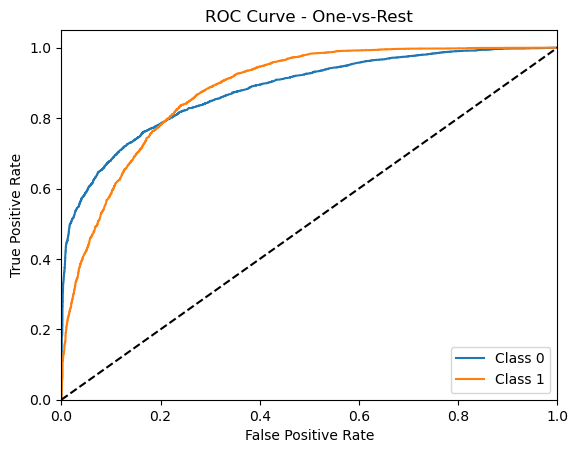

In [180]:
xg_metrics.plot_roc_curve_ovr()

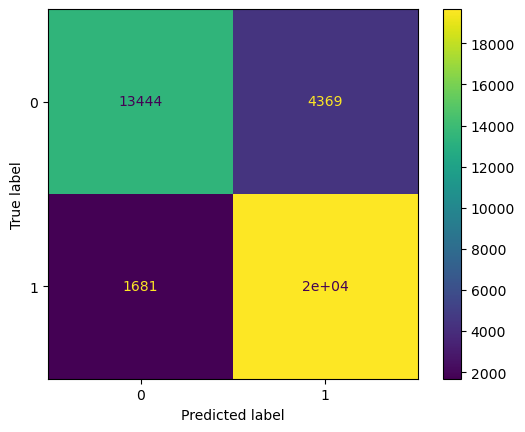

In [181]:
y_train_pred = xg_best_estimator.predict(X_train)
xg_metrics.plot_confusion_matrix(y_train, y_train_pred)

In [182]:
#Saving grid searched file for future use
xg_file = 'XGBoost.pkl'
with open (xg_file,'wb') as file:
  pickle.dump(xg_best_estimator, file)